In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Bidirectional
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
def load_dataset():
    imdb = keras.datasets.imdb
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
    return train_data,train_labels,test_data,test_labels,imdb

In [0]:
def get_reversed_word_mapping(imdb):
    word_index = imdb.get_word_index()
    word_index = {k:(v+3) for k,v in word_index.items()} 
    word_index["<PAD>"] = 0
    word_index["<START>"] = 1
    word_index["<UNK>"] = 2  # unknown
    word_index["<UNUSED>"] = 3
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
    return reverse_word_index,word_index

In [0]:
def decode_review(reverse_word_index,text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [0]:
def preprocessing_data(train_data,test_data,word_index):
    train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                            value=word_index["<PAD>"],
                                                            padding='post',
                                                            maxlen=256)
    test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                           value=word_index["<PAD>"],
                                                           padding='post',
                                                           maxlen=256)
    return train_data,test_data

In [0]:
def create_validation_set(train_data,train_labels):
    x_val = train_data[:10000]
    partial_x_train = train_data[10000:25000]

    y_val = train_labels[:10000]
    partial_y_train = train_labels[10000:25000]

    return x_val,partial_x_train,y_val,partial_y_train

In [0]:
def define_lstm_model():
    vocab_size = 10000
    
    model = Sequential()
    model.add(Embedding(vocab_size, 300, input_length=256))
    model.add(Bidirectional(LSTM(128, dropout=0.5, recurrent_dropout=0.2,return_sequences=True)))
    model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.2,return_sequences=True)))
    model.add(Bidirectional(LSTM(128,dropout=0.5, recurrent_dropout=0.2,return_sequences=False)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [0]:
def train_model(partial_x_train,partial_y_train,x_val,y_val):
    history = model.fit(partial_x_train,
                        partial_y_train,
                        epochs=7,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1,
                        callbacks=[tensorBoardCallback])

    return history

In [0]:
def plot_graph_loss_vs_epochs(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [11]:
train_data,train_labels,test_data,test_labels,imdb = load_dataset()
reverse_word_index,word_index = get_reversed_word_mapping(imdb)
train_data,test_data = preprocessing_data(train_data,test_data,word_index)
model = define_lstm_model()
model.compile(optimizer=tf.train.AdamOptimizer(),loss='binary_crossentropy',metrics=['accuracy'])
tensorBoardCallback = TensorBoard(log_dir='./logs', write_graph=True)
x_val,partial_x_train,y_val,partial_y_train = create_validation_set(train_data,train_labels)

1646592/1641221 [==============================] - 0s 0us/step


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256, 256)          439296    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256, 256)          394240    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 4,230,357
Trainable params: 4,230,357
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = train_model(partial_x_train,partial_y_train,x_val,y_val)

Train on 15000 samples, validate on 10000 samples
Epoch 1/7
15000/15000 [==============================] - 201s 13ms/step - loss: 0.1376 - acc: 0.9499 - val_loss: 0.4629 - val_acc: 0.8467
Epoch 2/7
15000/15000 [==============================] - 201s 13ms/step - loss: 0.3073 - acc: 0.8797 - val_loss: 0.4748 - val_acc: 0.8020
Epoch 3/7
15000/15000 [==============================] - 201s 13ms/step - loss: 0.3575 - acc: 0.8574 - val_loss: 0.4647 - val_acc: 0.8055
Epoch 4/7
15000/15000 [==============================] - 200s 13ms/step - loss: 0.2682 - acc: 0.8993 - val_loss: 0.4104 - val_acc: 0.8464
Epoch 5/7
15000/15000 [==============================] - 202s 13ms/step - loss: 0.2038 - acc: 0.9245 - val_loss: 0.3891 - val_acc: 0.8477
Epoch 6/7
15000/15000 [==============================] - 201s 13ms/step - loss: 0.1567 - acc: 0.9457 - val_loss: 0.3905 - val_acc: 0.8516
Epoch 7/7
15000/15000 [==============================] - 202s 13ms/step - loss: 0.1291 - acc: 0.9550 - val_loss: 0.4208 - 

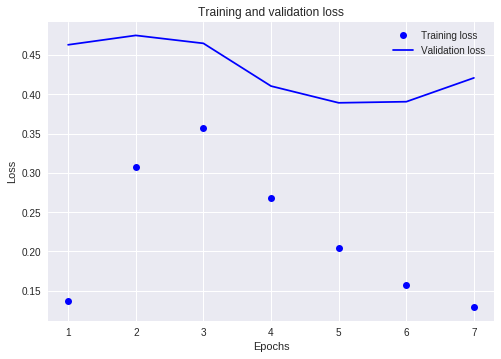

In [18]:
plot_graph_loss_vs_epochs(history)

In [19]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 820s 33ms/step
[0.4717454729938507, 0.83928]


In [0]:
from google.colab import files
files.download('logs/events.out.tfevents.1539198570.3413a1e2315d') 